In [5]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e4/cf/8f9305cc0ea26badbbb3558ecae54c04a245429f03168f7fad502f8a5b25/torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -------- ------------------------------- 0.4/1.7 MB 11.6 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 16.4 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 18.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from collections import defaultdict
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt

In [ ]:
# Dataset class
class TemporalFloodDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.data = []
        self.max_seq_len = 8

        flood_events = defaultdict(list)
        nonflood = []

        for fname in os.listdir(directory):
            if fname.endswith('.pt'):
                if fname.startswith('NonFlood'):
                    nonflood.append(os.path.join(directory, fname))
                elif fname.startswith('PreFlood'):
                    event_id = fname.split('_')[3]
                    flood_events[event_id].append(os.path.join(directory, fname))

        for f in nonflood:
            self.data.append((f, 0))

        for event_id, files in flood_events.items():
            files = sorted(files)
            self.data.append((files, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item, label = self.data[idx]

        try:
            if label == 0:
                img = torch.load(item)
                C, H, W = img.shape
                pad = [torch.zeros(C, H, W)] * (self.max_seq_len - 1)
                imgs = [img] + pad
                img = torch.stack(imgs)
            else:
                imgs = [torch.load(p) for p in item]
                seq_len = len(imgs)
                C, H, W = imgs[0].shape
                if seq_len < self.max_seq_len:
                    pad = [torch.zeros(C, H, W)] * (self.max_seq_len - seq_len)
                    imgs.extend(pad)
                else:
                    imgs = imgs[:self.max_seq_len]
                img = torch.stack(imgs)
        except Exception as e:
            print(f"Error loading sample {idx} ({item}): {e}")
            raise e

        return img, torch.tensor(label, dtype=torch.long)


In [ ]:
# Model
class TemporalCNN(nn.Module):
    def __init__(self, in_channels, time_steps):
        super().__init__()
        total_in_channels = in_channels * time_steps

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=total_in_channels, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B, T * C, H, W)
        return self.conv(x)

[Epoch 1] Loss: 4.1737, Train Acc: 42.86%
[Epoch 2] Loss: 4.1569, Train Acc: 60.71%
[Epoch 3] Loss: 4.1413, Train Acc: 67.86%
[Epoch 4] Loss: 4.1169, Train Acc: 71.43%
[Epoch 5] Loss: 4.0977, Train Acc: 76.19%
[Epoch 6] Loss: 4.0787, Train Acc: 82.14%
[Epoch 7] Loss: 4.0604, Train Acc: 88.10%
[Epoch 8] Loss: 4.0571, Train Acc: 88.10%
[Epoch 9] Loss: 4.0592, Train Acc: 90.48%
[Epoch 10] Loss: 4.0098, Train Acc: 95.24%


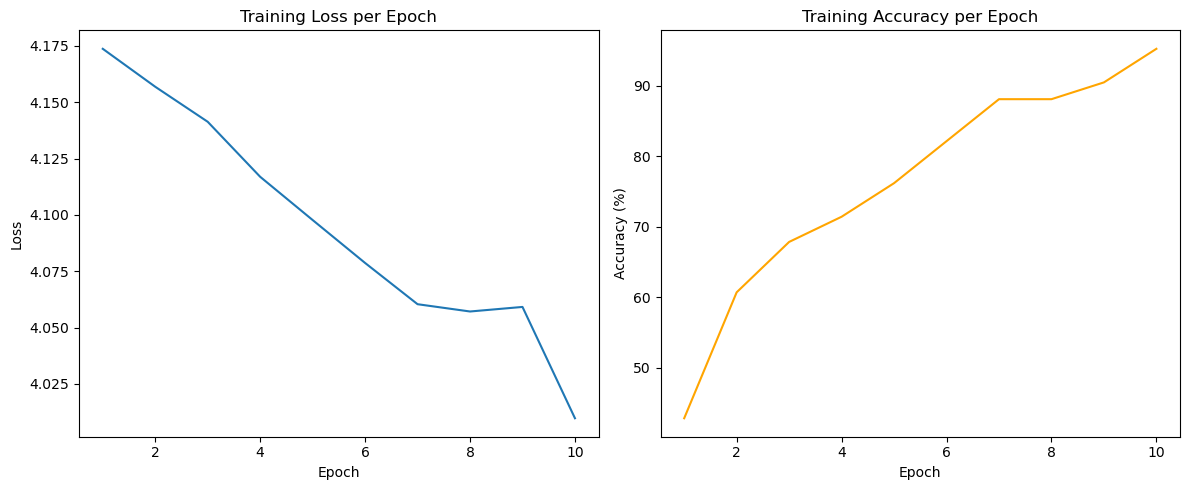


🧪 Final Test Accuracy: 95.24%


In [66]:

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
in_channels = 19
time_steps = 8
model = TemporalCNN(in_channels=in_channels, time_steps=time_steps).to(device)

# Xavier weight init
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)
model.apply(init_weights)

# Load dataset
dataset = TemporalFloodDataset('preprocessed')
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epoch_losses = []
epoch_accuracies = []

for epoch in range(10):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device).float()

        if torch.isnan(x).any() or torch.isinf(x).any():
            print(f"NaN or Inf detected in input data in epoch {epoch+1}, batch {i}")
            continue

        optimizer.zero_grad()
        out = model(x)

        if torch.isnan(out).any():
            print(f"NaN logits detected in epoch {epoch+1}, batch {i}")
            continue

        loss = criterion(out.squeeze(1), y)
        if torch.isnan(loss).any():
            print(f"NaN loss detected in epoch {epoch+1}, batch {i}")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        if y.size(0) > 0:
            pred = (torch.sigmoid(out) > 0.5).squeeze(1).long()
            correct += (pred == y.long()).sum().item()
            total += y.size(0)

    epoch_loss = total_loss
    epoch_accuracy = 100 * correct / total if total > 0 else 0

    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%")
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

# Plot training metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), epoch_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), epoch_accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')

plt.tight_layout()
plt.show()


# Evaluation on test set
model.eval()
test_correct, test_total = 0, 0

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device).float()
        out = model(x_test)
        pred = (torch.sigmoid(out) > 0.5).squeeze(1).long()
        test_correct += (pred == y_test.long()).sum().item()
        test_total += y_test.size(0)

test_acc = 100 * test_correct / test_total
print(f"\n🧪 Final Test Accuracy: {test_acc:.2f}%")
